In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import seaborn as sns
plt.rcParams['figure.dpi'] = 150
sns.set()
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose

# Extracción de datos - Yahoo Finances
## Últimos 3 años del precio de Ethereum (ETH) y Bitcoin (BTC) en EUR €

In [2]:
# End and star dates
end = datetime.today()
start = datetime(end.year-3,end.month,end.day)

BTC = pd.read_csv('../data/bitcoin.csv')
ETH = pd.read_csv('../data/ethereum.csv')

# Grab data from yahoo using Pandas Datareader
#BTC = pdr.DataReader('BTC-EUR','yahoo',start,end)
#ETH = pdr.DataReader('ETH-EUR','yahoo',start,end)

# Save data
#BTC.to_csv('../data/bitcoin.csv')
#ETH.to_csv('../data/ethereum.csv')

# Data train/test split - 2019 for testing
#BTC.iloc[:-154, :].to_csv('../data/bitcoin_train.csv')
#BTC.iloc[-154:, :].to_csv('../data/bitcoin_test.csv')

#ETH.iloc[:-154, :].to_csv('../data/ethereum_train.csv')
#ETH.iloc[-154:, :].to_csv('../data/ethereum_test.csv')

## Dataframes info

In [3]:
BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 7 columns):
Date         1096 non-null object
High         1096 non-null float64
Low          1096 non-null float64
Open         1096 non-null float64
Close        1096 non-null float64
Volume       1096 non-null int64
Adj Close    1096 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 60.0+ KB


In [4]:
ETH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 7 columns):
Date         1096 non-null object
High         1096 non-null float64
Low          1096 non-null float64
Open         1096 non-null float64
Close        1096 non-null float64
Volume       1096 non-null int64
Adj Close    1096 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 60.0+ KB


## Plot inicial

<Figure size 432x288 with 0 Axes>

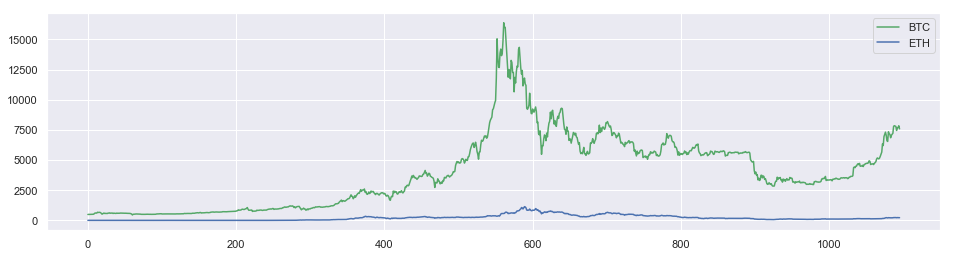

In [5]:
plt.clf();
plt.figure(figsize=(16, 4));
plt.plot(BTC['Adj Close'], color='g');
plt.plot(ETH['Adj Close'], color='b');
plt.legend(['BTC', 'ETH'])

# Análisis de datos - Bitcoin
## Estadísticos básicos

In [6]:
BTC.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03,1096.000000
mean,4101.204122,3833.727748,3973.004149,3979.569018,6.374960e+07,3979.569018
std,3200.293070,2910.411375,3071.435870,3071.713450,9.095233e+07,3071.713450
min,508.779999,431.480011,457.190002,457.190002,1.071120e+06,457.190002
25%,1031.147461,978.027512,997.307495,1004.719986,1.247301e+07,1004.719986
50%,3552.824951,3388.310059,3487.614990,3489.989990,3.789813e+07,3489.989990
75%,5856.905151,5633.802490,5744.229858,5746.052490,7.455576e+07,5746.052490
max,16670.939453,15760.450195,16374.540039,16376.299805,1.254620e+09,16376.299805


## Evolución del precio de Bitcoin

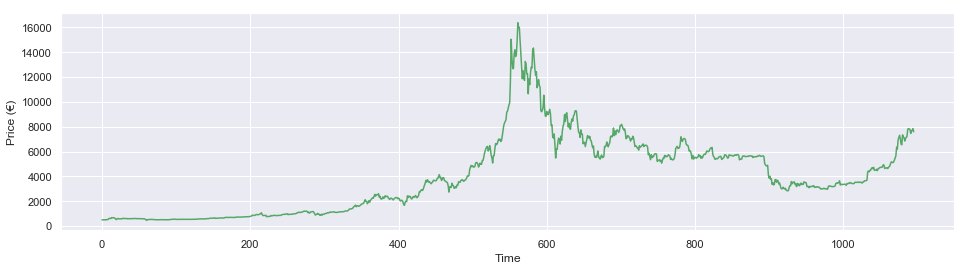

In [7]:
plt.figure(figsize=(16, 4))
plt.plot(BTC[['Adj Close']], color='g')
plt.xlabel('Time');
plt.ylabel('Price (€)');
plt.show();

El precio del bitcoin sufre un aumento exponencial a partir de mayo de 2017, hasta alcanzar un máximo de 16,376.30 € el 16 de diciembre de 2017. A partir de ese momento se produce una bajada de precio irregulat hasta abril de 2019 donde se aprecia una subida.

En los últimos meses se intuye una subida exponencial.

In [8]:
BTC.loc[BTC['Adj Close'].idxmax()]

Date         2017-12-16
High            16540.8
Low               14693
Open            14879.8
Close           16376.3
Volume        244926363
Adj Close       16376.3
Name: 561, dtype: object

In [9]:
candles = go.Candlestick(x=BTC.index,
                open=BTC['Open'],
                high=BTC['High'],
                low=BTC['Low'],
                close=BTC['Close'])
data = [candles]
py.iplot(data, filename='simple_candlestick')

## Normalidad

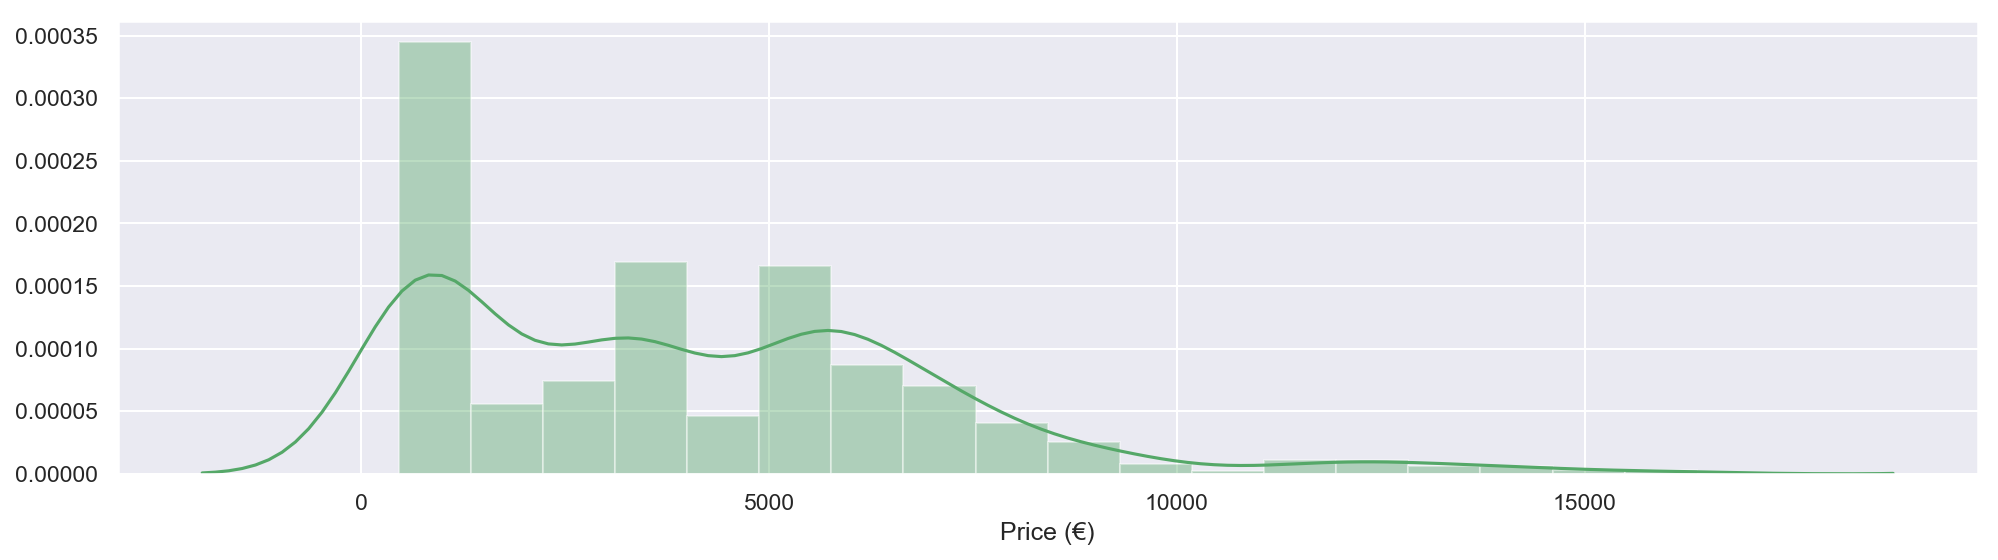

In [17]:
plt.figure(figsize=(16, 4))
sns.distplot(BTC[['Adj Close']].values.flatten(), axlabel='Price (€)', color='g');

La función de densidad muestra un comportamiento trimodal, existiendo almenos 3 distribuciones en los datos.

La mayoría de valores se sitúan en el bin más cercano al cero, dado que no fue hasta mayo de 2015 cuando el bitcoin empezó a cobrar interés. La función de densidad no señala normalidad en los datos.

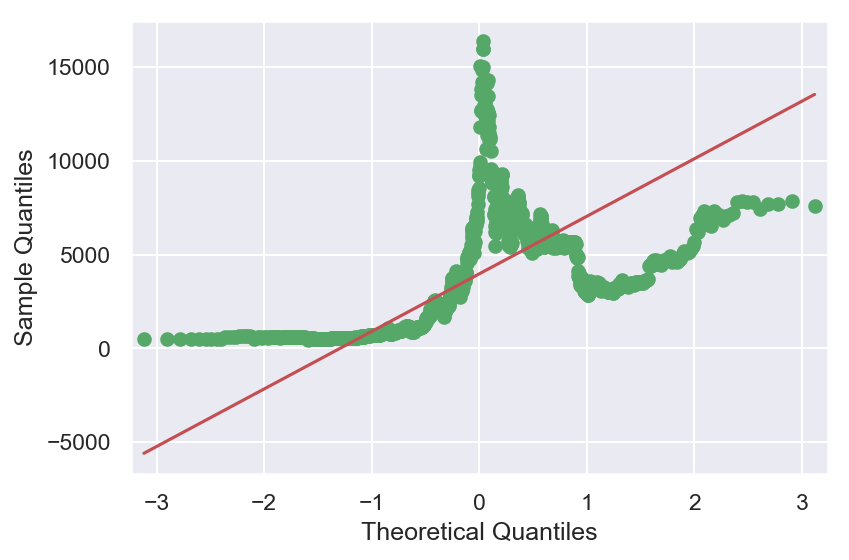

In [18]:
qqplot(BTC[['Adj Close']], line='s', color='g');

El gráfico Q-Q corrobora la no normalidad dado que la distribución de los datos dista enormemente de una distribución normal ideal.

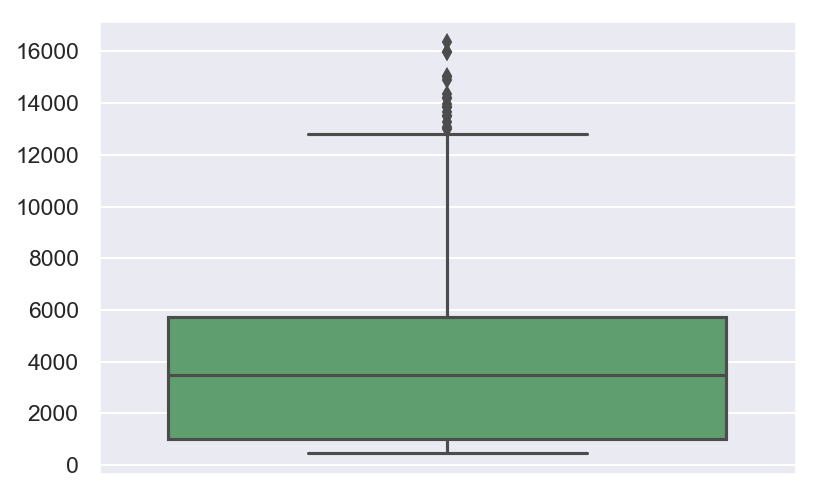

In [19]:
sns.boxplot(BTC[['Adj Close']], orient='v', color='g');

El 50% de los datos se situa entorno a los valores 1500 y 5900€. Existen una cantidad considerable de valores considerados como outliers, valores que superan los 12500€. Estos valores corresponden a la subida producida entre el 3 y 23 de diciembre de 2017, fechas en las que el bitcoin alzanzó valores máximos.

## Descomposición de serie temporal de BTC
### Modelo aditivo

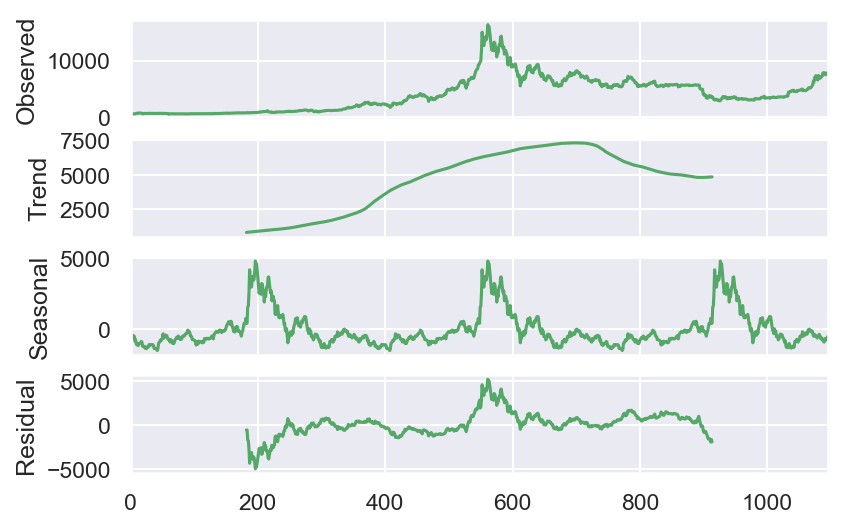

In [20]:
btc_decompose_aditive = seasonal_decompose(BTC[['Adj Close']], model='aditive', freq=365)

fig, axes = plt.subplots(4, 1, sharex=True);

btc_decompose_aditive.observed.plot(ax=axes[0], legend=False, color='g');
axes[0].set_ylabel('Observed');
btc_decompose_aditive.trend.plot(ax=axes[1], legend=False, color='g');
axes[1].set_ylabel('Trend');
btc_decompose_aditive.seasonal.plot(ax=axes[2], legend=False, color='g');
axes[2].set_ylabel('Seasonal');
btc_decompose_aditive.resid.plot(ax=axes[3], legend=False, color='g');
axes[3].set_ylabel('Residual');

### Modelo multiplicativo

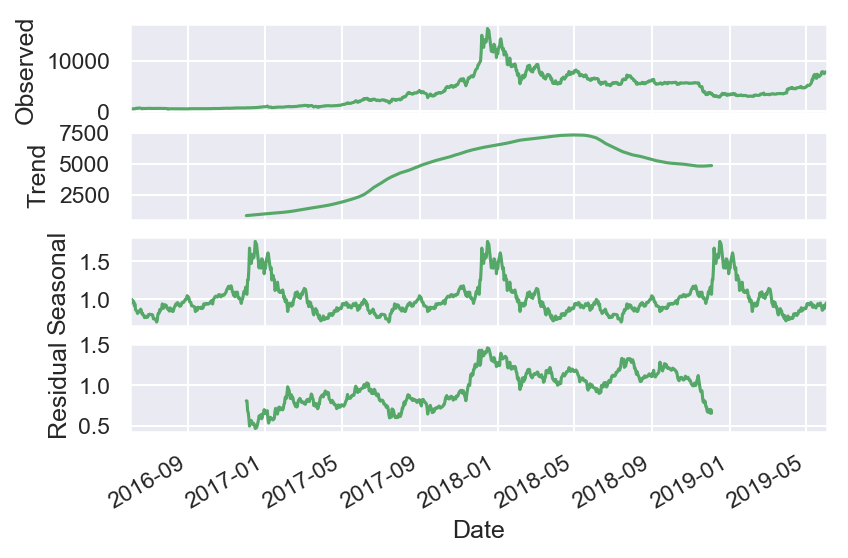

In [28]:
btc_decompose_multiplicative = seasonal_decompose(BTC[['Adj Close']], model='multiplicative', freq=365)
fig, axes = plt.subplots(4, 1, sharex=True);

btc_decompose_multiplicative.observed.plot(ax=axes[0], legend=False, color='g');
axes[0].set_ylabel('Observed');
btc_decompose_multiplicative.trend.plot(ax=axes[1], legend=False, color='g');
axes[1].set_ylabel('Trend');
btc_decompose_multiplicative.seasonal.plot(ax=axes[2], legend=False, color='g');
axes[2].set_ylabel('Seasonal');
btc_decompose_multiplicative.resid.plot(ax=axes[3], legend=False, color='g');
axes[3].set_ylabel('Residual');

En ambos modelos, la tendencia obtenida es semejante. Se observa una clara tendencia creciente hasta julio de 2018, momento en el que la tendencia empieza a ser decreciente.

El modelo aditivo genera una estacionalidad y unos residuos mayores en magnitud, variando desde 0 hasta 5.000. El modelo multiplicativo genera residuos más irregulares.

# Análisis de datos - Ethereum

## Estadísticos básicos

In [13]:
ETH.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03,1096.000000
mean,228.219881,207.917564,218.611724,218.822591,2.288417e+07,218.822591
std,230.159683,207.053503,219.657982,219.597120,3.243791e+07,219.597120
min,7.000000,5.580000,6.240000,6.240000,6.349400e+04,6.240000
25%,18.410001,15.992500,17.180000,17.735001,2.776133e+06,17.735001
50%,175.720001,155.339996,166.915001,167.560005,1.404200e+07,167.560005
75%,317.344994,287.264992,306.580002,306.650002,2.943969e+07,306.650002
max,1175.650024,1062.599976,1144.050049,1144.050049,3.439806e+08,1144.050049


## Evolución de precio de Ethereum

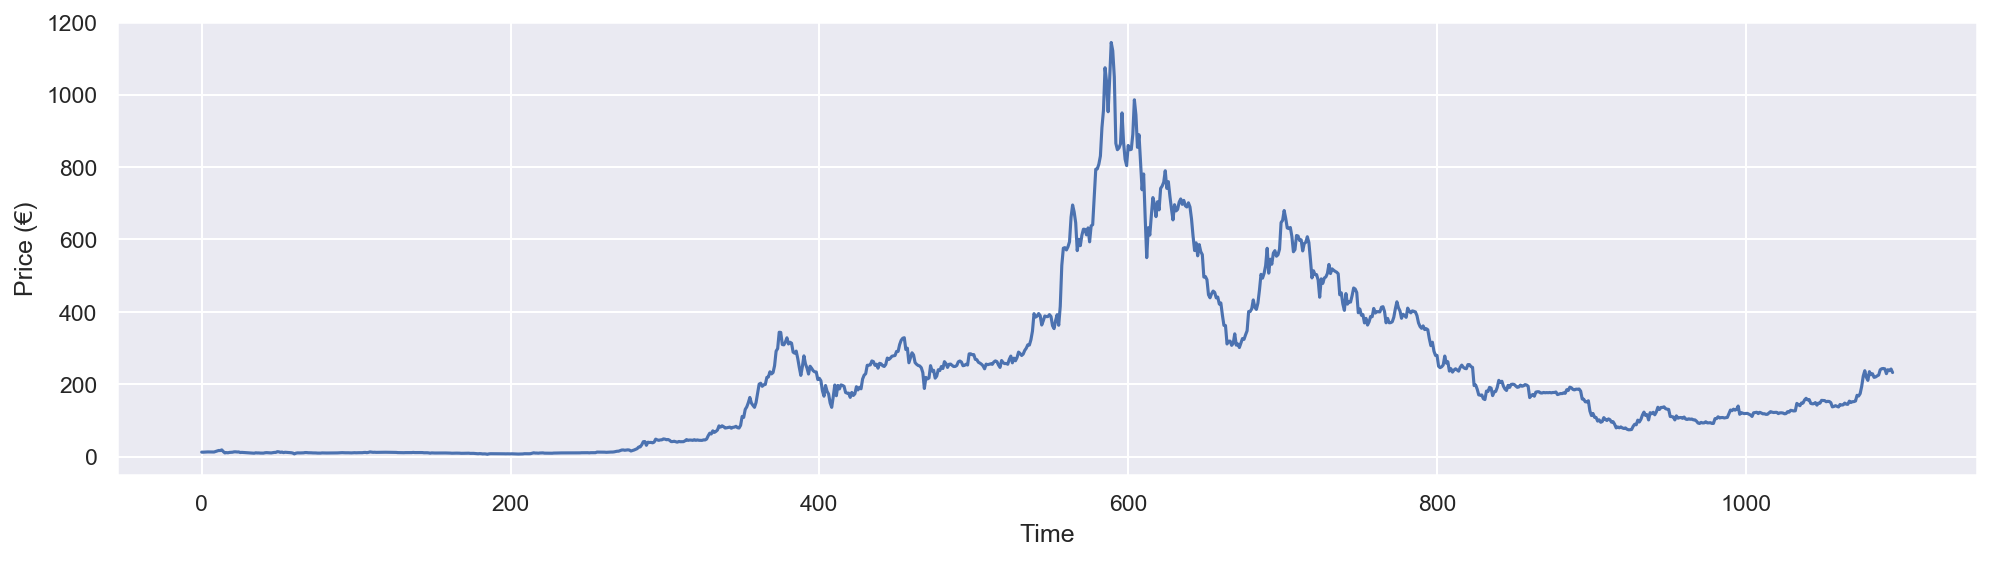

In [21]:
plt.figure(figsize=(16, 4))
plt.plot(ETH[['Adj Close']], color='b')
plt.xlabel('Time');
plt.ylabel('Price (€)');

El valor de Ethereum es mucho mas moderado, alcanzando un máximo de 1.144€ el 13 de enero de 2018. Su precio, desde entonces, experimentó una fuerte caida hasta mayo de 2018, donde subió momentaneamente para volver a experimentar una caida más moderada.

In [17]:
ETH.loc[ETH['Adj Close'].idxmax()]

High         1.175650e+03
Low          1.043170e+03
Open         1.043750e+03
Close        1.144050e+03
Volume       4.358723e+07
Adj Close    1.144050e+03
Name: 2018-01-13 00:00:00, dtype: float64

## Normalidad

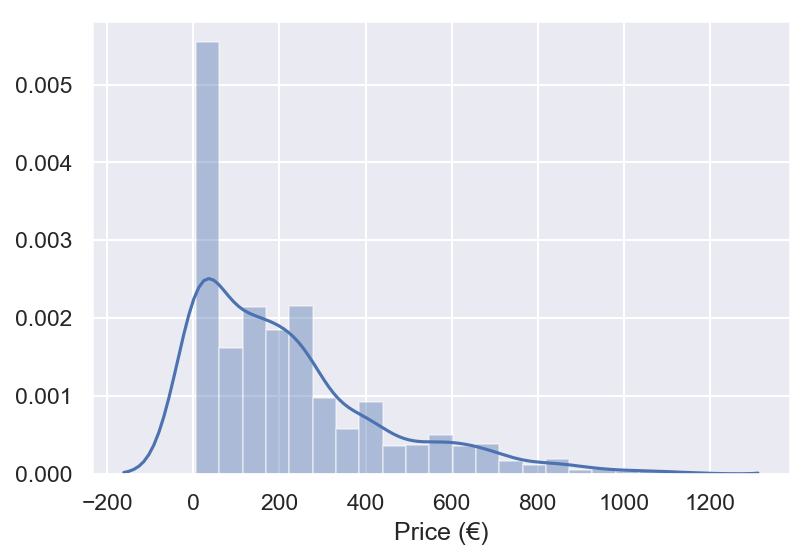

In [32]:
sns.distplot(ETH[['Adj Close']].values.flatten(), axlabel='Price (€)', color='b');

Al igual que ocurría con el precio del Bitcoin, la mayoría de valores se agrupan entorno al cero debido a que durante muchos años esta moneda carecía de valor.

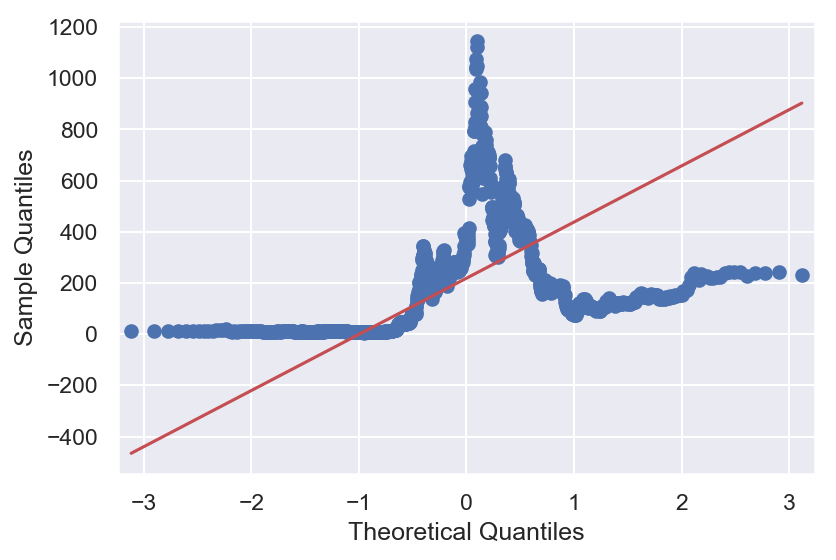

In [33]:
qqplot(ETH[['Adj Close']], line='s', color='b');

## Descomposición de serie temporal de ETH
### Modelo aditivo

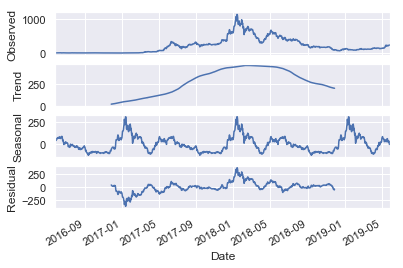

In [21]:
eth_decompose_aditive = seasonal_decompose(ETH[['Adj Close']], model='aditive', freq=365);

fig, axes = plt.subplots(4, 1, sharex=True);

eth_decompose_aditive.observed.plot(ax=axes[0], legend=False, color='b');
axes[0].set_ylabel('Observed');
eth_decompose_aditive.trend.plot(ax=axes[1], legend=False, color='b');
axes[1].set_ylabel('Trend');
eth_decompose_aditive.seasonal.plot(ax=axes[2], legend=False, color='b');
axes[2].set_ylabel('Seasonal');
eth_decompose_aditive.resid.plot(ax=axes[3], legend=False, color='b');
axes[3].set_ylabel('Residual');

### Modelo multiplicativo

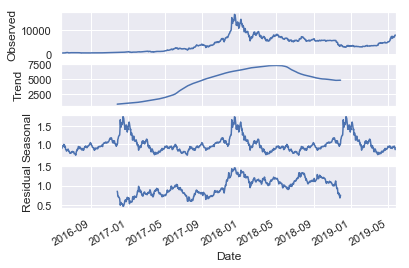

In [23]:
eth_decompose_multiplicative = seasonal_decompose(BTC[['Adj Close']], model='multiplicative', freq=365)
fig, axes = plt.subplots(4, 1, sharex=True);

eth_decompose_multiplicative.observed.plot(ax=axes[0], legend=False, color='b');
axes[0].set_ylabel('Observed');
eth_decompose_multiplicative.trend.plot(ax=axes[1], legend=False, color='b');
axes[1].set_ylabel('Trend');
eth_decompose_multiplicative.seasonal.plot(ax=axes[2], legend=False, color='b');
axes[2].set_ylabel('Seasonal');
eth_decompose_multiplicative.resid.plot(ax=axes[3], legend=False, color='b');
axes[3].set_ylabel('Residual');

In [22]:
candles = go.Candlestick(
    x=ETH.index,
    open=ETH['Open'],
    high=ETH['High'],
    low=ETH['Low'],
    close=ETH['Close'],
    increasing=dict(line=dict(color= '#375598'))
)
data = [candles]
py.iplot(data, filename='eth_candlestick')